## This code creates control variates based on 1st order polynomials and compare the error in estimating E_f(h(X)) using them with a classical Monte Carlo method

## Sources:

## "Zero Variance Differential Geometric Markov Chain Monte Carlo Algorithms", Papamarkou and al, 2014

In [5]:
# scientific computing library
import numpy as np
# visualization tools
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.stats import multivariate_normal

## Creation of a new function with the control variate

In [6]:
# m first draws from the distribution we are interested in, m<=100
#returns a 2d-array
def draws(m, samples):#samples are a 2d-array
    return(samples[:m])    

##function z, only works in the case of a standard normal distribution, z is defined in the article by Papamarkou
#def z(x):
#    return(x/2) 

#z(x) returns a 2d-array of size dim parameter \times ..., , z is defined in the article by Papamarkou
# x is  an array of size ( dim parameter \times ...), , cov 2d array, mean 1d-array
def z(x):
    x=np.atleast_2d(x).T#convert x to a 2d-array
    return(0.5*np.linalg.solve(cov, x-np.atleast_2d(mean).T))

#"true" mean of f(X)
def true_mean(f):
    return(np.mean([np.mean(f(np.random.multivariate_normal(mean, cov, 100))) for i in range (1000)]))

#error based on a classic Monte Carlo Method and using  m samples
#returns a scalar; np.log10 needs or not to be added depending on the cases
def ErrorFunction( true_mean, samples, f):
    return((abs(np.sum(f(samples))/len(samples)-true_mean)))

#coefficient estimator a_hat estimated using the first n samples, a_hat is defined in the article by Papamarkou
    #returns a 2d-array of size dim parameter \times 1
def a_hat(n, f, samples):
    samples_a_hat=draws(n, samples)
    #Sample variance of z, Var is a 2d-array
    Var=(z(samples_a_hat)-np.atleast_2d(np.mean(z(samples_a_hat), axis=1)).T).dot((z(samples_a_hat)-np.atleast_2d(np.mean(z(samples_a_hat), axis=1)).T).T)
    Var= Var/(n-1)
    #Covariance of the target function and z
    Cov=(z(samples_a_hat)-np.atleast_2d(np.mean(z(samples_a_hat), axis=1)).T)*(f(samples_a_hat)-np.mean(f(samples_a_hat))).T
    Cov= np.sum(Cov, axis=1)/(n-1)
    Cov=np.atleast_2d(Cov).T
    return(-np.linalg.inv(Var).dot(Cov))

#New function built with the control variate (1st degree polynome P); newf is defined in the article by Papamarkou
    #by the function g_tilde
    #returns a 2d-array of dim 1 x ...
def newf(x, n, f, samples):
    return(f(x).T+a_hat(n, f, samples).T.dot(z(x))) 

## Plot the function h, the distribution against which we integrate and the control variate

In [12]:
###PLots of the functions we want to integrate, the control variate and the distribution, in the case of a 1D 
#integration space
def plot_functions_1D(f):
    # x-axis variable
    x = np.linspace(-5, 5)
    x=np.atleast_2d(x).T#convert x to a 2d-array
    np.random.seed(123)#fix the seed to make this plot repoductible
    samples = np.random.multivariate_normal(mean, cov, 100)
    # y-axis variable
    y_f = f(x)#function we want to integrate
    y_newf = -a_hat(50, f, samples).T.dot(z(x))#control variate
    y_newf =y_newf.T
    y_distri=(1/(np.sqrt(2 * np.pi)) *np.exp( - x**2 / 2 ))#distribution
    # visualize
    axes = plt.gca()
    axes.set_ylim([-1.5,1.5])
    plt.plot(x, y_f, label="h")
    plt.plot(x, y_newf, label="Control variate")
    plt.plot(x, y_distri, label="pdf", linestyle="-.")
    plt.title("Plot for h(x)=x")
    plt.legend();
    return(plt.show())

###PLots of the functions we want to integrate, the control variate and the distribution, in the case of a 2D 
#integration space
def plot_functions_2D(f):
    #plot the function f
    x = np.outer(np.linspace(-3, 3, 50), np.ones(50))
    y = x.copy().T
    z = (x+ y)#function we want to integrate
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, y, z, rstride=3, cstride=3, linewidth=1, antialiased=True, color='red')
    
    #plot the distribution with an offset
    rv = multivariate_normal(mean, cov)#ditribution
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Z= rv.pdf(pos)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-40, cmap=cm.viridis)
    # Adjust the limits 
    ax.view_init(27, -21)
    ax.set_zlim(-40,40)
    ax.text2D(0.8, 0.6, "h", transform=ax.transAxes)
    ax.text2D(0.16, 0.35, "pdf", transform=ax.transAxes)
    return(plt.show())

## Functions to plot the (expectation of ) the Error or logError

In [13]:
##Plots of the error against the number of Monte Carlo samples
###    n=30 and n=50 (Number of samples used for assessing the value of a_hat)
def visu(g, true_mean):
    # x-axis variable
    # x-axis variable
    x1 = np.arange(start=1, stop=101, step=10) 
    x2 = np.arange(start=31, stop=101, step=10)
    x3 = np.arange(start=51, stop=101, step=10)
    # y-axis variable
    y1= np.zeros(len(x1))
    y2= np.zeros(len(x2))
    y3= np.zeros(len(x3))
    np.random.seed(123)
    samples = np.random.multivariate_normal(mean, cov, 100)
    for i in range (0, len(x1)):
        y1[i] = ErrorFunction(true_mean, samples[:x1[i]], g)
    for i in range(0, len(x2)): 
        y2[i] = ErrorFunction(true_mean, samples[30:x2[i]], f=lambda x:newf(x, 30, g, samples))
    for i in range(0, len(x3)): 
        y3[i] = ErrorFunction(true_mean, samples[50:x3[i]], f=lambda x:newf(x, 50, g, samples))    
    # visualize
    plt.plot(x1, y1, label= "Classic Monte Carlo method", linestyle="-",  marker="o",linewidth=1) 
    plt.plot(x2, y2, label= "n="+ str(30), linestyle="-",  marker="o",linewidth=1) 
    plt.plot(x3, y3, label= "n="+ str(50), linestyle="-",  marker="o",linewidth=1)    
    plt.title("Plot for f="+ str(g))
    plt.xlabel("m=Number of Monte Carlo Samples")
    plt.ylabel("|Error|")
    plt.legend();
    return(plt.show())
    
#Plots of the expectation of the error against the number of Monte Carlo samples’  
#   N number of replicates, n: number of samples used  for assessing the value of a_hat   #N >=n     
def visu_expectation_error(g, true_mean, N):
    x1 = np.arange(start=1, stop=101, step=10) 
    x2 = np.arange(start=31, stop=101, step=10)
    x3 = np.arange(start=51, stop=101, step=10)  
    y1=np.zeros((N, len(x1)))
    y2=np.zeros((N, len(x2)))
    y3=np.zeros((N, len(x3)))
    for i in range(N):
        samples = np.random.multivariate_normal(mean, cov, 100)
        for j in range (0, len(x1)):
            y1[i, j] = ErrorFunction(true_mean, samples[:x1[j]], g)
        for j in range (0, len(x2)):
            y2[i, j] = ErrorFunction(true_mean, samples[30:x2[j]], f=lambda x:newf(x, 30, g, samples))
        for j in range (0, len(x3)):
            y3[i, j] = ErrorFunction(true_mean, samples[50:x3[j]], f=lambda x:newf(x, 50, g, samples)) 
        # making sure that the length of the two variables match
        # visualize
    plt.plot(x1, 1/N*np.sum(y1, axis=0),label= "Classic Monte Carlo method", linestyle="-",  marker="o",linewidth=1)
    plt.plot(x2, 1/N*np.sum(y2, axis=0), label= "n="+ str(30), linestyle="-",  marker="o",linewidth=1)
    plt.plot(x3, 1/N*np.sum(y3, axis=0), label= "n="+ str(50), linestyle="-",  marker="o",linewidth=1) 
    plt.title("Plot for h(x)=x")
    plt.xlabel("m=Number of Monte Carlo Samples")
    plt.ylabel("E|Error|")
    plt.legend();
    return(plt.show())  

## Functions we want to integrate with respect to the probability density f  

In [14]:
#h1 returns a len(x) x 1 2d-array such that h1(x)=\sum_{i=1}^{n} x_i
def h1(x):#x is a 2d-array
    return(x.dot(np.ones((len(x[0]), 1))))

#sphere function
def h2(x):
    return (x**2).dot(np.ones((len(x[0]), 1)))

#h3 returns a len(x) x 1 2d-array such that h3(x)=\sum_{i=1}^{n} x_i^3
def h3(x):
    return (x**3).dot(np.ones((len(x[0]), 1)))  

## Example in the case of a one-dimensional space \mathcal{X}

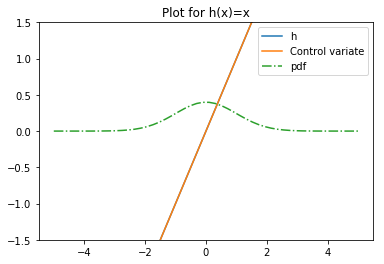

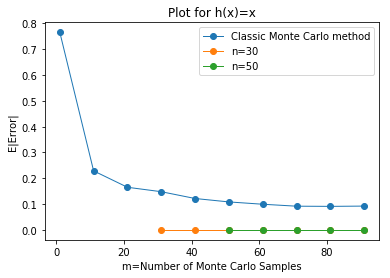

In [15]:
#Choice of the mean of the multivariate normal distribution
mean = np.array([0])#1d-array
#Choice of the variance of the multivariate normal distribution
cov = np.array([[1]])#2d-array

plot_functions_1D(h1)
visu_expectation_error(h1, 0, 100)

## Example in the case of a two-dimensional space \mathcal{X}

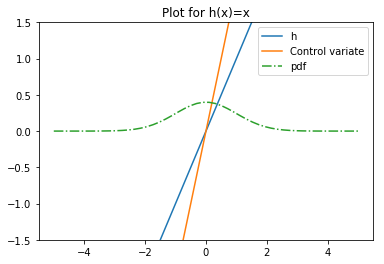

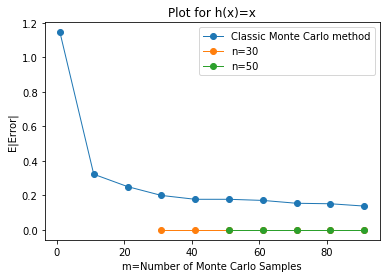

In [16]:
#Choice of the mean of the multivariate normal distribution
mean = np.array([0, 0])
#Choice of the variance of the multivariate normal distribution
cov = np.array([[1, 0], [0, 1]] )

plot_functions_1D(h1)
visu_expectation_error(h1, 0, 100)